In [1]:
dataset_path    = "../LabelData/dataset.npy"

Dropping 279 / 833 images (≥95% blank)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 10, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 10, 10, 32)     │         5,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 128)       │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,253 (129.89 KB)

 Trainable params: 33,253 (129.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.7004 - loss: 0.5259 - val_auc: 0.7478 - val_loss: 0.4763 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7918 - loss: 0.4286 - val_auc: 0.7624 - val_loss: 0.4490 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7892 - loss: 0.4274 - val_auc: 0.7719 - val_loss: 0.4350 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8220 - loss: 0.3992 - val_auc: 0.7756 - val_loss: 0.4338 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8341 - loss: 0.3880 - val_auc: 0.7815 - val_loss: 0.4268 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8499 - loss: 0.3755 - val_auc: 0.7844 - val_loss: 0.4282 - learning_rate: 0.0010
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8451 - loss: 0.3845 - val_auc: 0.7880 - val_loss: 0.4224 - learning_rate: 0.0010
Epoch 8/50
11

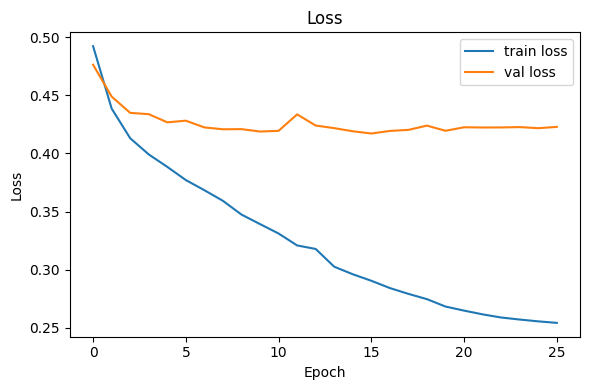

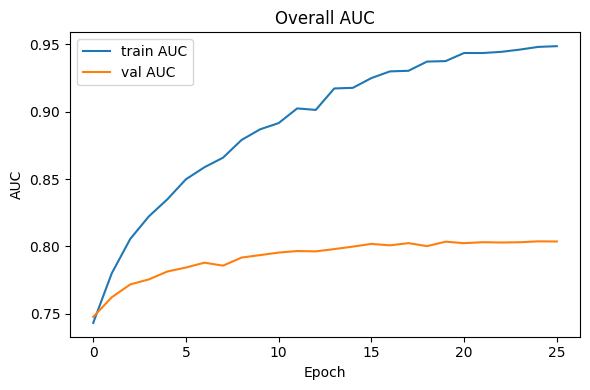

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Per‐class ROC AUC on validation set:
  Class 0               : AUC = 0.759
  Class 1               : AUC = 0.816
  Class 2               : AUC = 0.739
  Class 3               : AUC = 0.709
  Class 4               : AUC = 0.742

Per‐class Accuracy on validation set:
  Class 0               : Accuracy = 0.731
  Class 1               : Accuracy = 0.826
  Class 2               : Accuracy = 0.850
  Class 3               : Accuracy = 0.880
  Class 4               : Accuracy = 0.898


In [2]:
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- 1. Load your raw dataset ---
# Assume `raw_dataset` is a list of (img_array, species_idx) pairs,
# where img_array has shape (10,10,19) and species_idx is an int 0..C-1.
# For example, you might have loaded it like:
raw = np.load(dataset_path, allow_pickle=True)
raw_dataset = [(item[1], item[0]) for item in raw]
#
# Here we just reference `raw_dataset`.
# ----------------------------------------------------------------

# --- 2. Group by identical images into sets of species labels ---
def hash_image(arr: np.ndarray) -> bytes:
    """Produce a hashable key for a numpy array of floats."""
    # We use tostring of bytes; if memory is an issue you can md5 it instead.
    return arr.tobytes()
import hashlib

def hash_image(arr: np.ndarray, decimals: int = 6) -> str:
    """
    Round the array to `decimals` places, then hash via MD5.
    This groups “bit-noisy” floats that are equal up to rounding,
    and gives a compact string key.
    """
    # 1) Round to reduce spurious bit-noise
    rounded = np.round(arr, decimals=decimals)
    # 2) Convert to bytes
    b = rounded.tobytes()
    # 3) MD5 digest (hex string)
    return hashlib.md5(b).hexdigest()

# Rebuild your “bags” mapping
from collections import defaultdict

bags = defaultdict(set)
image_lookup = {}

for img, species in raw_dataset:
    key = hash_image(img, decimals=6)
    bags[key].add(species)
    if key not in image_lookup:
        image_lookup[key] = img.copy()   # store one representative

# Now reconstruct unique images + multi‐species sets
images    = []
label_sets = []
for key, species_set in bags.items():
    images.append(image_lookup[key])
    label_sets.append(species_set)
images = np.stack(images, axis=0)  # shape (N_unique, 10, 10, 19)

# Reconstruct unique arrays + label sets
images = []
label_sets = []
for key, species_set in bags.items():
    images.append(image_lookup[key])
    label_sets.append(species_set)
images = np.stack(images, axis=0)        # shape (N,10,10,19)
images_raw = images.copy()

# --- 3. Multi-hot encode labels ---
all_species = sorted({s for sset in label_sets for s in sset})
mlb = MultiLabelBinarizer(classes=all_species)
Y = mlb.fit_transform(label_sets)        # shape (N, C), dtype int

# --- 4. Filter out fully blank images (all channels NaN) ---
# Blank if every pixel in every band is NaN:
valid = ~np.all(np.isnan(images).reshape(images.shape[0], -1), axis=1)
images = images[valid]
Y      = Y[valid]

# --- 4b. (Optional) Drop images with > X% blank pixels ---
# First, rebuild a per‐image “blankness” mask over the original 19 bands
# Note: `images_raw` should be your (N,10,10,19) array *before* you zero‐filled NaNs  
# (so you might need to keep that around).

# Suppose you still have `images_raw` from step 4, before you do mask/zero‐fill:
# images_raw = images.copy()  

# Compute a boolean mask: True where *all* bands are NaN
blank_pixel_mask = np.all(np.isnan(images_raw), axis=-1)   # shape (N,10,10)

# Compute fraction of blank pixels per image
blank_frac = blank_pixel_mask.reshape(images_raw.shape[0], -1).mean(axis=1)  
# blank_frac[i] is between 0.0 (no blank pixels) and 1.0 (all pixels blank)

# Choose your threshold:
X = 0.95     # e.g. drop any image with ≥30% completely‐blank pixels

# Keep only the “good” images
keep = blank_frac < X
print(f"Dropping {np.count_nonzero(~keep)} / {len(keep)} images (≥{X*100:.0f}% blank)")

# Filter both your features and labels:
images_raw = images_raw[keep]
label_sets  = [ls for ls, k in zip(label_sets, keep) if k]

# --- 5. Build a mask channel & replace NaNs with zero ---
# mask = 1 where any band is non-NaN; 0 where all NaN
mask = np.any(~np.isnan(images), axis=-1, keepdims=True).astype('float32')
# zero-fill the 19 bands
images = np.nan_to_num(images, nan=0.0).astype('float32')
# concatenate mask as 20th channel
images = np.concatenate([images, mask], axis=-1)  # (N,10,10,20)

# --- 5b. Per-channel normalization of the 19 data bands ---
# Compute mean/std only over the original 19 channels
means = np.nanmean(images[..., :19], axis=(0,1,2))
stds  = np.nanstd( images[..., :19], axis=(0,1,2))
# Broadcast and normalize
images[..., :19] = (images[..., :19] - means) / (stds + 1e-6)


# --- 6. Train/Val split ---
X_train, X_val, y_train, y_val = train_test_split(
    images, Y, test_size=0.2, random_state=42
)

# --- 7. Build the MIL CNN model ---
num_classes = Y.shape[1]  # C
inp = Input(shape=(10,10,20))  # 19 bands + 1 mask

# Instance encoder
x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
# Flatten spatial dims into instance dimension
instances = layers.Reshape((10*10, 64))(x)          # (batch,100,64)
# Per-instance embedding
inst_embed = layers.Dense(128, activation='relu')(instances)  # (batch,100,128)
# MIL pooling (max over the 100 instances)
bag_embed = layers.GlobalMaxPooling1D()(inst_embed)          # (batch,128)
# Multi-label output
out = layers.Dense(num_classes, activation='sigmoid')(bag_embed)

model = Model(inputs=inp, outputs=out)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)
model.summary()

# --- 8. Callbacks for training ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# --- 9. Train ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)

# --- 10. Final evaluation ---
val_loss, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"Final val loss: {val_loss:.4f}, val AUC: {val_auc:.4f}")

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# 1. Plot training history
def plot_history(history):
    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Overall AUC (if you logged it)
    if 'auc' in history.history:
        plt.figure(figsize=(6,4))
        plt.plot(history.history['auc'], label='train AUC')
        plt.plot(history.history['val_auc'], label='val AUC')
        plt.title('Overall AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Call this after training:
plot_history(history)


# 2. Compute per-class AUC on the validation set
# ----------------------------------------------------------------------------
# You need:
#   - X_val, y_val  : your validation features and multi-hot labels
#   - model         : your trained Keras model
#   - class_names   : a list/array of your class labels, e.g.
#                     mlb.classes_ if you used sklearn's MultiLabelBinarizer

# Predict probabilities
y_pred = model.predict(X_val)    # shape (n_val, C)
y_true = y_val                   # shape (n_val, C)
class_names = mlb.classes_       # or your own list of length C

# Compute and print per‐class ROC-AUC
print("Per‐class ROC AUC on validation set:")
for i, cls in enumerate(class_names):
    # roc_auc_score requires at least one positive & one negative example per class
    try:
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        print(f"  Class {cls:<15} : AUC = {auc:.3f}")
    except ValueError as e:
        print(f"  Class {cls:<15} : could not compute AUC ({e})")
        
# --- 2b. Compute per‐class accuracy on the validation set ---
# y_pred: numpy array of shape (n_val, C), floats in [0,1]
# y_true: numpy array of shape (n_val, C), ints in {0,1}

# 1) Binarize predictions at 0.5
y_pred_label = (y_pred >= 0.5).astype(int)

# 2) Compute accuracy for each class (over all samples)
#    accuracy_i = (# correct on class i) / (total samples)
per_class_acc = (y_pred_label == y_true).sum(axis=0) / y_true.shape[0]

print("\nPer‐class Accuracy on validation set:")
for cls, acc in zip(class_names, per_class_acc):
    print(f"  Class {cls:<15} : Accuracy = {acc:.3f}")


In [3]:
subset_acc = np.all(y_pred_label == y_true, axis=1).mean()
print(f"\nSubset Accuracy (exact match): {subset_acc:.3f}")



Subset Accuracy (exact match): 0.407


In [4]:
intersection = np.logical_and(y_true, y_pred_label).sum(axis=1)
union = np.logical_or(y_true, y_pred_label).sum(axis=1)
samplewise_acc = (intersection / np.clip(union, a_min=1, a_max=None)).mean()
print(f"Sample-wise Accuracy (Jaccard): {samplewise_acc:.3f}")


Sample-wise Accuracy (Jaccard): 0.422


In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score
for i, cls in enumerate(class_names):
    p = precision_score(y_true[:, i], y_pred_label[:, i], zero_division=0)
    r = recall_score(y_true[:, i], y_pred_label[:, i], zero_division=0)
    f1 = f1_score(y_true[:, i], y_pred_label[:, i], zero_division=0)
    print(f"  Class {cls:<15} : Precision = {p:.3f}, Recall = {r:.3f}, F1 = {f1:.3f}")


  Class 0               : Precision = 0.700, Recall = 0.671, F1 = 0.685
  Class 1               : Precision = 0.852, Recall = 0.479, F1 = 0.613
  Class 2               : Precision = 1.000, Recall = 0.038, F1 = 0.074
  Class 3               : Precision = 0.000, Recall = 0.000, F1 = 0.000
  Class 4               : Precision = 0.000, Recall = 0.000, F1 = 0.000


In [6]:
# Macro-average: unweighted mean over classes
macro_precision = precision_score(y_true, y_pred_label, average='macro', zero_division=0)
macro_recall    = recall_score(y_true, y_pred_label, average='macro', zero_division=0)
macro_f1        = f1_score(y_true, y_pred_label, average='macro', zero_division=0)

# Micro-average: global TP, FP, FN summed across all labels
micro_precision = precision_score(y_true, y_pred_label, average='micro', zero_division=0)
micro_recall    = recall_score(y_true, y_pred_label, average='micro', zero_division=0)
micro_f1        = f1_score(y_true, y_pred_label, average='micro', zero_division=0)

print(f"\nMacro-Averaged Scores:")
print(f"  Precision = {macro_precision:.3f}, Recall = {macro_recall:.3f}, F1 = {macro_f1:.3f}")

print(f"\nMicro-Averaged Scores:")
print(f"  Precision = {micro_precision:.3f}, Recall = {micro_recall:.3f}, F1 = {micro_f1:.3f}")



Macro-Averaged Scores:
  Precision = 0.510, Recall = 0.238, F1 = 0.275

Micro-Averaged Scores:
  Precision = 0.745, Recall = 0.397, F1 = 0.518


In [7]:
np.sum(y_val, axis=0)


array([73, 48, 26, 20, 17])